In [2]:
import daspi as dsp
DPI = 120
dsp.__version__

'0.5.0'

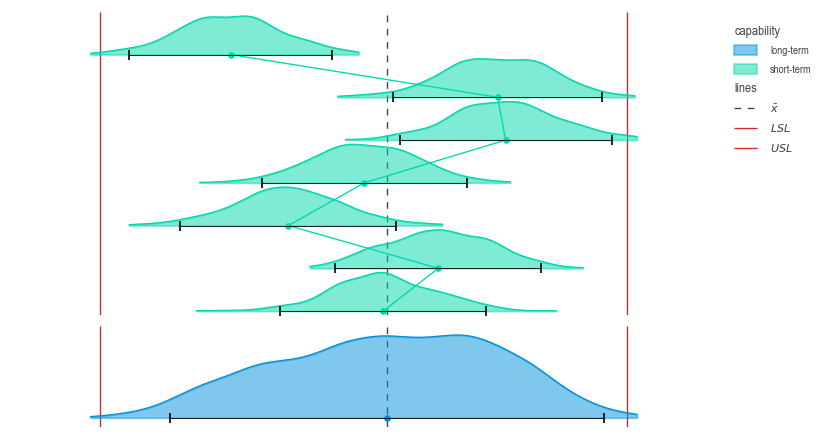

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from typing import Any
from typing import Dict

import seaborn as sns
sns.displot

np.random.seed(3)
N_SAMPLES = 500
HEIGHT = 0.9
means = np.random.random(7)-0.5
df_batch = pd.DataFrame()

for i, mean in enumerate(means):
    pos = i
    data = pd.DataFrame({
        'capability': 'short-term',
        'position': pos,
        'values': stats.norm.rvs(size=N_SAMPLES, loc=mean, scale=0.15)})
    df_batch = pd.concat([df_batch, data], axis=0, ignore_index=True)
df_tot = pd.DataFrame({
    'capability': 'long-term',
    'position': 0,
    'mean': '0',
    'values': df_batch['values']})

chart = dsp.JointChart(
        source=pd.concat([df_batch, df_tot]),
        target='values',
        feature='position',
        hue='capability',
        ncols=1,
        nrows=2,
        height_ratios=[3, 1],
        target_on_y=False,
        sharex=True,
        sharey=False,
    ).stripes(
        stripes=[dsp.StripeLine(
            r'\bar x', df_tot['values'].mean(), orientation='vertical')],
        spec_limits=(-0.75, 0.75),
    ).label(
    )

def axes_settings(ax) -> None:
    ax.xaxis.set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set(ylim=(-0.1, None), xlim=(-1, 1))

kw_base: Dict[str, Any] = dict(
    feature='position',
    target='values',
    target_on_y=False,
    ax=chart.axes[0][0],
    color=dsp.COLOR.PALETTE[1])
kw_kde: Dict[str, Any] = dict(
    height=HEIGHT,
    fill=True,
    ignore_feature=False)
kw_spread: Dict[str, Any] = dict(
    marker='o',
    agreement=4,
)
dsp.CenterLocation(source=df_batch, center_points=False, **kw_base)()
for pos, group in df_batch.groupby('position'):
    dsp.GaussianKDE(source=group, f_base=pos, **(kw_base | kw_kde))()
    dsp.SpreadWidth(source=group, **(kw_base | kw_spread))()

kw_base['ax'] = chart.axes[1][0]
kw_base['color'] = color=dsp.COLOR.PALETTE[0]
dsp.GaussianKDE(source=df_tot, f_base=0, **(kw_base | kw_kde))()
dsp.SpreadWidth(source=df_tot, **(kw_base | kw_spread))()

for ax in chart.axes.flat:
    axes_settings(ax)